\begin{align}
    \partial_t p(x,t) &= -\nabla_x \cdot (\nabla_x\log q(x) p(x,t)) + \frac 12 g^2(t) \nabla_x^2 p(x,t)\\
    \partial_t p(x,t) &= -\nabla_x^2\log q(x) p(x,t) - \nabla_x\log q(x) \cdot \nabla_x p(x,t) + \frac 12 g^2(t) \nabla_x^2 p(x,t)\\
    \partial_t p(x,t) &= \mathcal H p(x,t)
\end{align}

\begin{align}
    \mathcal H = -\nabla_x^2\log q(x) - \nabla_x\log q(x) \cdot \nabla_x  + \frac 12 g^2(t) \nabla_x^2
\end{align}

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
sys.path.append("/n/home12/binxuwang/Github/DiffusionOperatorSpectra/core")
import torch as th 
import numpy as np
import matplotlib.pyplot as plt
from gaussian_mixture_lib import GaussianMixture, GaussianMixture_torch

### Visualizing and playing with Gaussian Mixture

In [3]:
sigma = 1
mus = th.tensor([[-1.0, 0.0], [1.0, 2.0], [1.0, -2.0]])
covs = th.repeat_interleave(th.eye(2).unsqueeze(0), 3, dim=0) * sigma ** 2
gmm = GaussianMixture_torch(mus, covs, th.tensor([0.3, 0.3, 0.4]))

/n/home12/binxuwang/Github/DiffusionOperatorSpectra/core/gaussian_mixture_lib.py:116: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.weights = torch.tensor(weights)


In [4]:
# visualize the density, score function vector field
xspan = np.linspace(-5, 5, 101)
yspan = np.linspace(-5, 5, 101)
XX, YY = np.meshgrid(xspan, yspan)
dx = xspan[1] - xspan[0]
dy = yspan[1] - yspan[0]
pnts = th.tensor(np.stack([XX, YY], axis=-1).reshape(-1, 2)).float()
score_vecs = gmm.score(pnts)
score_tsrs = score_vecs.reshape(*XX.shape, -1)
probs = gmm.pdf(pnts).reshape(*XX.shape)

(-5.0, 5.0, -5.0, 5.0)

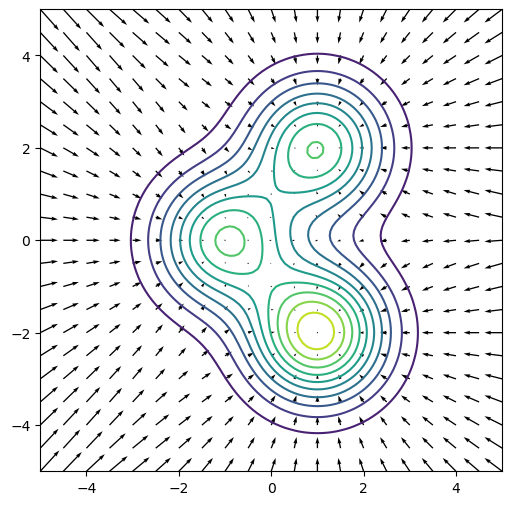

In [5]:
slc = slice(None, None, 5)
plt.figure(figsize=(6, 6))
plt.quiver(XX[slc, slc], YY[slc, slc], score_tsrs[slc, slc, 0], score_tsrs[slc, slc, 1])
plt.contour(XX, YY, probs, levels=10)
plt.axis("image")

(-5.0, 5.0, -5.0, 5.0)

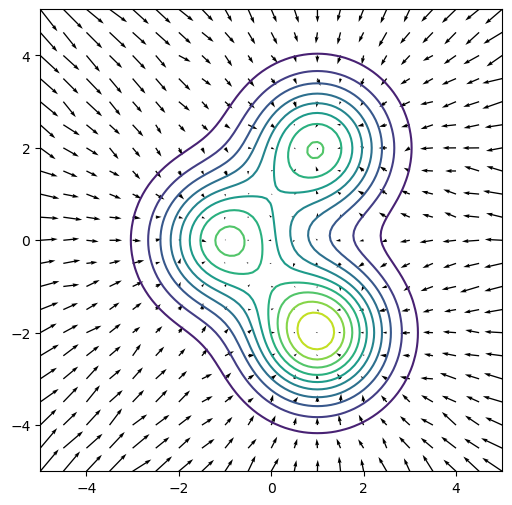

In [6]:
# add gaussian noise to the score function
noise_std = 0.3
noise = th.randn_like(score_vecs) * noise_std
score_vecs_noisy = score_vecs + noise
score_tsrs_noisy_tsrs = score_vecs_noisy.reshape(*XX.shape, -1)
slc = slice(None, None, 5)
plt.figure(figsize=(6, 6))
plt.quiver(XX[slc, slc], YY[slc, slc], 
           score_tsrs_noisy_tsrs[slc, slc, 0], 
           score_tsrs_noisy_tsrs[slc, slc, 1])
plt.contour(XX, YY, probs, levels=10)
plt.axis("image")

### Final ways to build diffusion operator

In [7]:
import numpy as np
from scipy.sparse import diags, kron, eye, diags_array
from scipy.sparse.linalg import eigs

def create_diff_operator(N_x, N_y, L_x, L_y):
    # Grid spacing in x and y directions
    dx = L_x / (N_x - 1)
    dy = L_y / (N_y - 1)
    # Central difference matrix in 1D for x and y
    D_x_1d = (1 / (2 * dx)) * diags([-1, 0, 1], [-1, 0, 1], shape=(N_x, N_x))
    D_y_1d = (1 / (2 * dy)) * diags([-1, 0, 1], [-1, 0, 1], shape=(N_y, N_y))
    DD_x_1d = (1 / dx**2) * diags([1, -2, 1], [-1, 0, 1], shape=(N_x, N_x))
    DD_y_1d = (1 / dy**2) * diags([1, -2, 1], [-1, 0, 1], shape=(N_y, N_y))
    I_x = eye(N_x)
    I_y = eye(N_y)
    # d/dx and d/dy operators for 2D
    D_x = kron(I_y, D_x_1d)
    D_y = kron(D_y_1d, I_x)
    # Laplacian operator
    Laplacian = kron(I_y, DD_x_1d) + kron(DD_y_1d, I_x)
    return D_x, D_y, Laplacian

In [8]:
def visualize_eigenmodes(eigenvalues, eigenvectors, shape, num2plot=20):
    plt.figure(figsize=(6, 4))
    plt.plot(eigenvalues.real, 'o-', label='real', alpha=0.7)
    plt.plot(eigenvalues.imag, 'o-', label='imag', alpha=0.7)
    plt.xlabel('rank')
    plt.ylabel('value')
    plt.title('Eigenvalues of the operator')
    plt.show()
    
    if isinstance(num2plot, int):
        num_eigenmodes = min(num2plot, eigenvectors.shape[1])
        eigenids = range(num_eigenmodes)
    elif isinstance(num2plot, tuple):
        eigenids = range(*num2plot)
        num_eigenmodes = len(eigenids)
    elif isinstance(num2plot, list):
        eigenids = num2plot
        num_eigenmodes = len(eigenids)
    nrow = int(np.ceil(num_eigenmodes / 5))
    fig, axes = plt.subplots(nrow, 5, figsize=(13, nrow* 2.4))
    axes = axes.flatten()
    for i, eigi in enumerate(eigenids):
        reshaped_eigenvec = eigenvectors[:, eigi].real.reshape(shape)
        ax = axes[i]
        im = ax.imshow(reshaped_eigenvec, cmap='coolwarm')
        ax.set_title(f'Eig {eigi+1} {eigenvalues[eigi].real:.2f}+{eigenvalues[eigi].imag:.2f}i')
        ax.axis('off')
        fig.colorbar(im, ax=ax)
    plt.tight_layout()
    plt.show()
    

In [21]:
sigma = 0.2
mus = th.tensor([[-1.0, 0.0], [1.0, 2.0], [1.0, -2.0]])
# covs = th.repeat_interleave(th.eye(2).unsqueeze(0), 3, dim=0) * sigma ** 2
covs = th.tensor([[[2.0, 0.5], [0.5, 1.0]],
                    [[1.0, -0.5], [-0.5, 1.0]],
                    [[1.0, 0.0], [0.0, 2.0]]]) * sigma ** 2
gmm = GaussianMixture_torch(mus, covs, th.tensor([0.3, 0.3, 0.4]))
# visualize the density, score function vector field
xspan = np.linspace(-5, 5, 101)
yspan = np.linspace(-5, 5, 101)
XX, YY = np.meshgrid(xspan, yspan)
dx = xspan[1] - xspan[0]
dy = yspan[1] - yspan[0]
assert dx == dy
pnts = th.tensor(np.stack([XX, YY], axis=-1).reshape(-1, 2)).float()
score_vecs = gmm.score(pnts)
score_tsrs = score_vecs.reshape(*XX.shape, -1)
probs = gmm.pdf(pnts).reshape(*XX.shape)
noise_std = 0.1
noise = th.randn_like(score_vecs) * noise_std
score_vecs_noisy = score_vecs + noise
# smoothing the noisy score function
# score_vecs_noisy_smoothed = th.nn.functional.gaussian_filter(score_vecs_noisy, sigma=1.0)

/n/home12/binxuwang/Github/DiffusionOperatorSpectra/core/gaussian_mixture_lib.py:116: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.weights = torch.tensor(weights)


In [34]:
sigma = 0.2
# mus = th.tensor([[-1.0, 0.0], [1.0, 2.0], [1.0, -2.0]])
# # covs = th.repeat_interleave(th.eye(2).unsqueeze(0), 3, dim=0) * sigma ** 2
# covs = th.tensor([[[2.0, 0.5], [0.5, 1.0]],
#                     [[1.0, -0.5], [-0.5, 1.0]],
#                     [[1.0, 0.0], [0.0, 2.0]]]) * sigma ** 2
# set mus as corners of a regular hexagon centered at the origin
# mus = th.tensor([[0.0, 0.0], [1.0, 0.0], [1.5, 0.5], [1.0, 1.0], [0.0, 1.0], [-0.5, 0.5]])
mus = th.tensor([np.cos(np.pi * np.arange(6) / 3), np.sin(np.pi * np.arange(6) / 3)]).T.float()
# covs = th.repeat_interleave(th.eye(2).unsqueeze(0), 3, dim=0) * sigma ** 2
covs = th.repeat_interleave(th.eye(2).unsqueeze(0), 6, dim=0) * sigma ** 2
gmm = GaussianMixture_torch(mus, covs, th.ones(mus.shape[0]) / mus.shape[0])
# visualize the density, score function vector field
xspan = np.linspace(-5, 5, 101)
yspan = np.linspace(-5, 5, 101)
XX, YY = np.meshgrid(xspan, yspan)
dx = xspan[1] - xspan[0]
dy = yspan[1] - yspan[0]
assert dx == dy
pnts = th.tensor(np.stack([XX, YY], axis=-1).reshape(-1, 2)).float()
score_vecs = gmm.score(pnts)
score_tsrs = score_vecs.reshape(*XX.shape, -1)
probs = gmm.pdf(pnts).reshape(*XX.shape)
noise_std = 0.1
noise = th.randn_like(score_vecs) * noise_std
score_vecs_noisy = score_vecs + noise
# smoothing the noisy score function
# score_vecs_noisy_smoothed = th.nn.functional.gaussian_filter(score_vecs_noisy, sigma=1.0)

/n/home12/binxuwang/Github/DiffusionOperatorSpectra/core/gaussian_mixture_lib.py:116: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.weights = torch.tensor(weights)


In [35]:
D_x, D_y, Laplacian = create_diff_operator(len(xspan), len(yspan), xspan[-1] - xspan[0], yspan[-1] - yspan[0])

In [38]:
Hopts =  Laplacian \
    - (D_x @ diags_array(score_vecs_noisy[:, 0].numpy()) + D_y @ diags_array(score_vecs_noisy[:, 1].numpy()))

In [12]:
Hopts =  \
    - (D_x @ diags_array(score_vecs_noisy[:, 0].numpy()) + D_y @ diags_array(score_vecs_noisy[:, 1].numpy()))

### Spectrum of full Fokker Planck

In [58]:
Hopts =  Laplacian \
    - (D_x @ diags_array(score_vecs_noisy[:, 0].numpy()) + D_y @ diags_array(score_vecs_noisy[:, 1].numpy()))

In [59]:
# is Hopts symmetric? no, it's not! 
print(Hopts.shape, "Hopts is symmetric?", (Hopts - Hopts.transpose()).nnz == 0)

(10201, 10201) Hopts is symmetric? False


In [60]:
num_eigenvalues = 25
eigenvalues, eigenvectors = eigs(Hopts, k=num_eigenvalues, which='SM')
# Reshape eigenvectors to 2D grid
eigenfunctions = [np.real(eigenvectors[:, i]).reshape(XX.shape) for i in range(num_eigenvalues)]
# Output first eigenvalue and eigenfunction
print("First eigenvalue:", eigenvalues[0])
print("First eigenfunction shape:", eigenfunctions[0].shape)

First eigenvalue: (1.3711254354120683e-13+0j)
First eigenfunction shape: (101, 101)


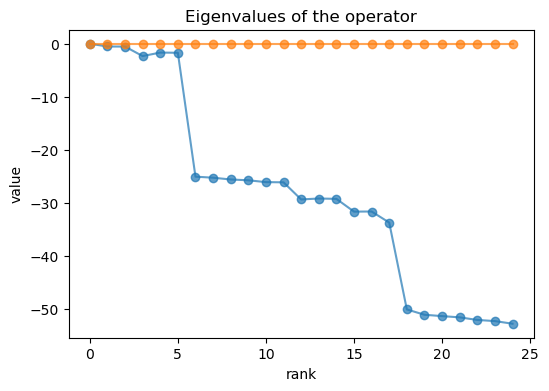

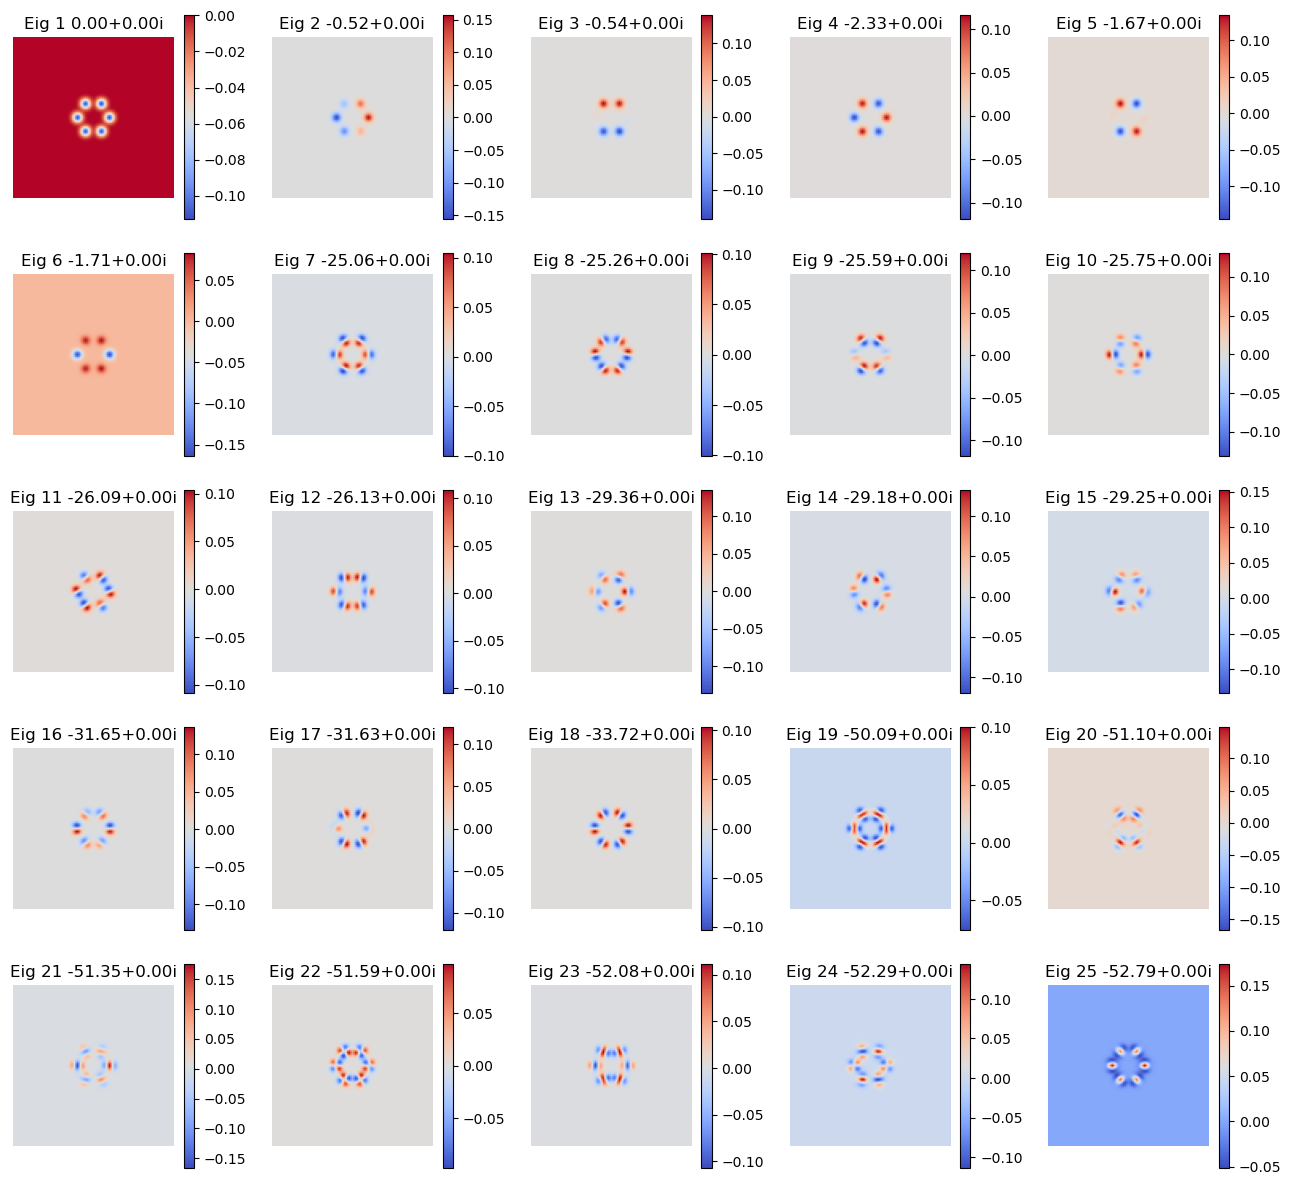

In [61]:
visualize_eigenmodes(eigenvalues, eigenvectors, XX.shape, num2plot=25)

### Spectrum of incompressible flow Fokker Planck (incorrect form)

Note the following one is also interesting! it's not the correct Fokker Planck operator but has really interesint spectra

In [54]:
Hopts =  Laplacian \
    - (diags_array(score_vecs_noisy[:, 0].numpy()) @ D_x + diags_array(score_vecs_noisy[:, 1].numpy()) @ D_y )

In [56]:
# is Hopts symmetric? no, it's not! 
print(Hopts.shape, "Hopts is symmetric?", (Hopts - Hopts.transpose()).nnz == 0)
num_eigenvalues = 25
eigenvalues, eigenvectors = eigs(Hopts, k=num_eigenvalues, which='SM')
# Reshape eigenvectors to 2D grid
eigenfunctions = [np.real(eigenvectors[:, i]).reshape(XX.shape) for i in range(num_eigenvalues)]
# Output first eigenvalue and eigenfunction
print("First eigenvalue:", eigenvalues[0])
print("First eigenfunction shape:", eigenfunctions[0].shape)

First eigenvalue: (-0.010273254720168783+0j)
First eigenfunction shape: (101, 101)


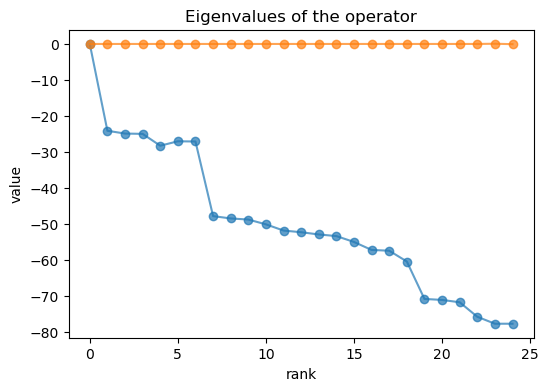

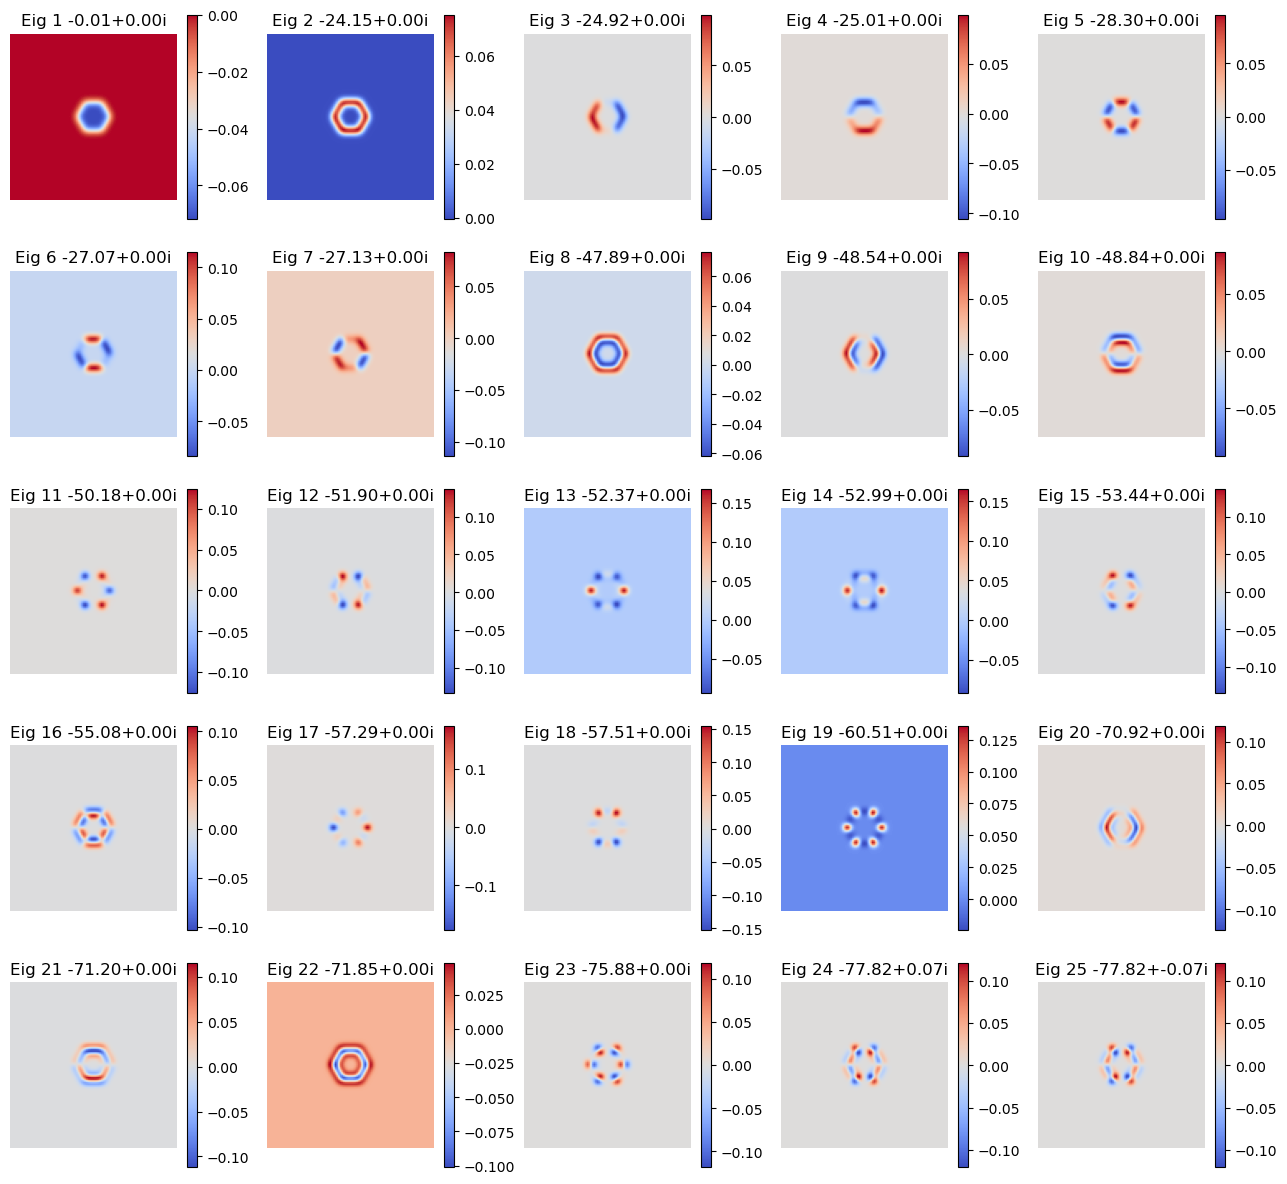

In [57]:
visualize_eigenmodes(eigenvalues, eigenvectors, XX.shape, num2plot=25)

### What if it is deterministic flow, i.e. no laplacain term?

Seems we cannot solve for the minimum eigenvalues.... 

In [51]:
Hopts = 0.01*  Laplacian \
    - (diags_array(score_vecs_noisy[:, 0].numpy()) @ D_x + diags_array(score_vecs_noisy[:, 1].numpy()) @ D_y )

In [52]:
# is Hopts symmetric? no, it's not! 
print(Hopts.shape, "Hopts is symmetric?", (Hopts - Hopts.transpose()).nnz == 0)

(10201, 10201) Hopts is symmetric? False


In [53]:
num_eigenvalues = 25
eigenvalues, eigenvectors = eigs(Hopts, k=num_eigenvalues, which='SM')
# Reshape eigenvectors to 2D grid
eigenfunctions = [np.real(eigenvectors[:, i]).reshape(XX.shape) for i in range(num_eigenvalues)]
# Output first eigenvalue and eigenfunction
print("First eigenvalue:", eigenvalues[0])
print("First eigenfunction shape:", eigenfunctions[0].shape)
# ArpackNoConvergence: ARPACK error -1: No convergence (102011 iterations, 5/25 eigenvectors converged)!! 

ArpackNoConvergence: ARPACK error -1: No convergence (102011 iterations, 5/25 eigenvectors converged)

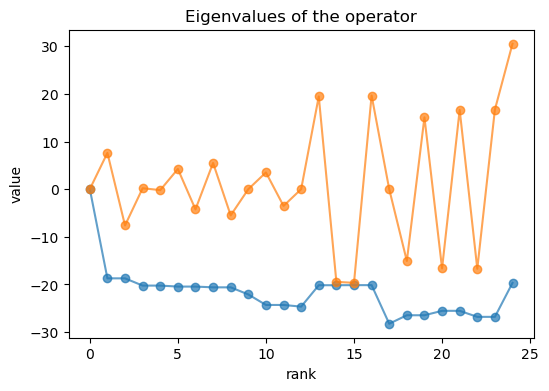

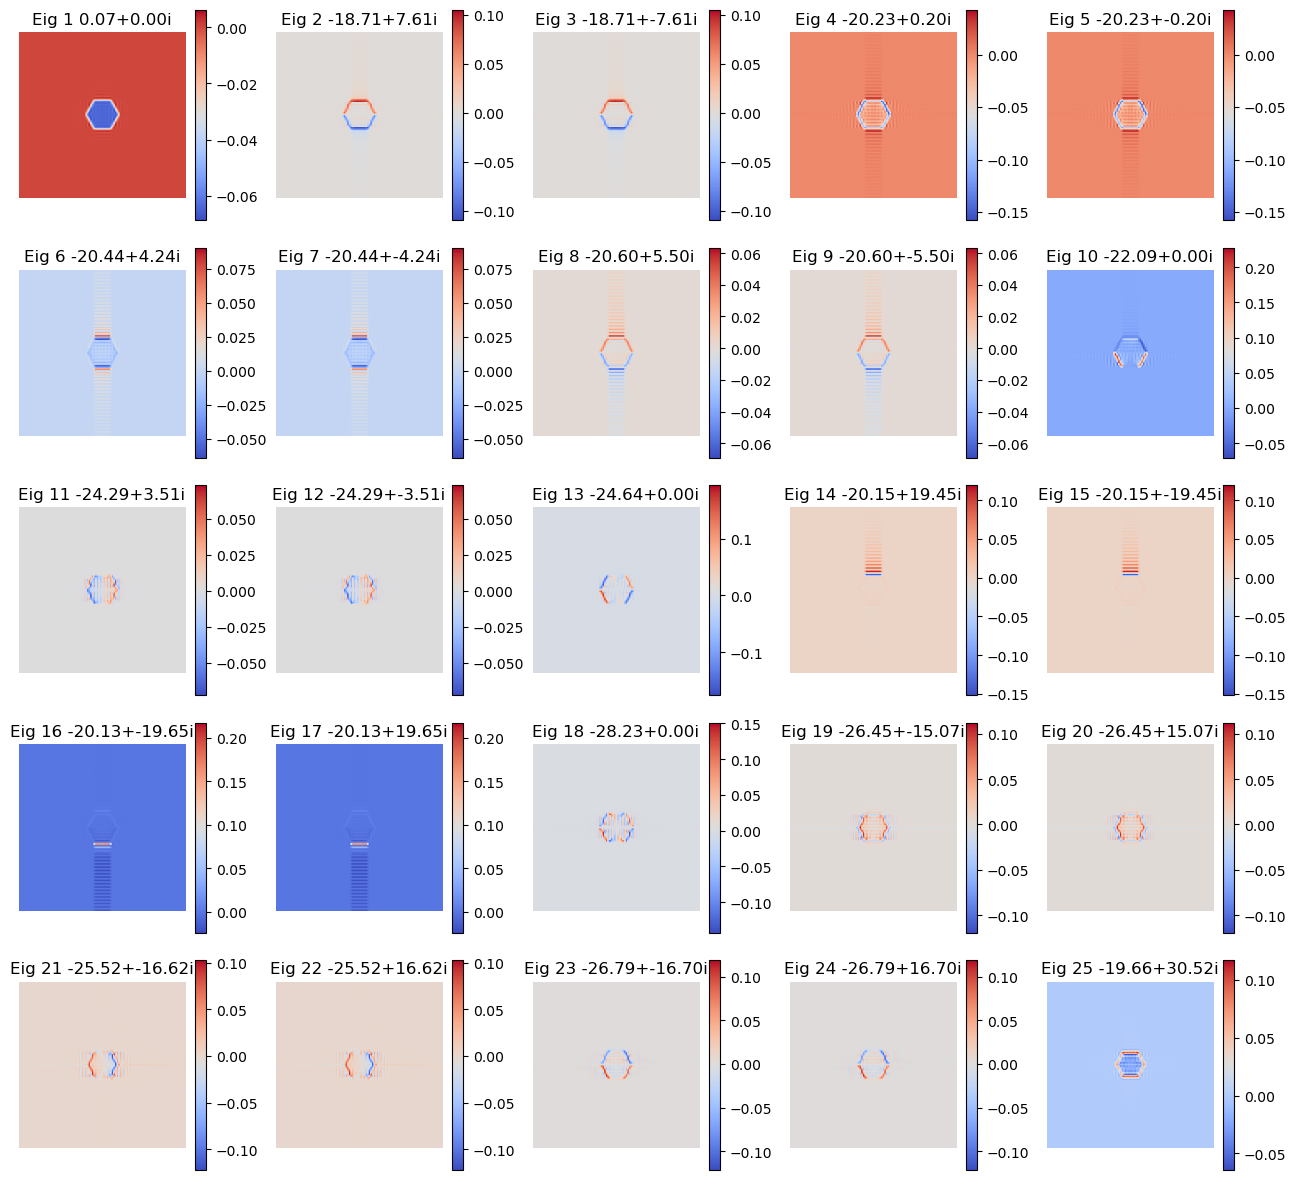

In [50]:
visualize_eigenmodes(eigenvalues, eigenvectors, XX.shape, num2plot=25)

## Poisson flow field

In [165]:
import torch
import torch.nn.functional as F
import scipy.special as sp
import numpy as np
import math
# Define the function S_d for a given dimension d
def S_d(d):
    return (2 * np.pi**(d/2)) / sp.gamma(d/2)


def compute_E_2d(r, sigma=1, Q=1):
    # Compute the error function and exponential term
    erf_term = torch.erf(r / (math.sqrt(2) * sigma))
    exp_term = torch.exp(-r**2 / (2 * sigma**2)) / (math.sqrt(2 * math.pi) * sigma)
    # Compute the electric field E(r)
    E_r = (Q / (2 * torch.pi * r)) * (erf_term - r * exp_term)
    return E_r

def compute_Phi_2d(r, sigma=1, Q=1, r0=1):
    erf_term = torch.erf(r / (math.sqrt(2) * sigma))
    Phi_r = (Q / (2 * torch.pi)) * torch.log(r / r0) * erf_term
    return Phi_r


def compute_E_ndim(r, ndim, sigma=1, Q=1):
    assert ndim > 2 and isinstance(ndim, int)
    # Compute the error function and exponential term
    erf_term = torch.erf(r / (math.sqrt(2) * sigma))
    exp_term = torch.exp(-r**2 / (2 * sigma**2)) / (math.sqrt(2 * math.pi) * sigma)
    # Compute the electric field E(r)
    # (d-2)S_{d}\epsilon_{d}r^{d-1}
    E_r = (Q / ((ndim - 2) * S_d(ndim) * r ** (ndim - 1))) * (erf_term - r * exp_term)
    return E_r
    

def compute_Phi_ndim(r, ndim, sigma=1, Q=1, r0=1):
    assert ndim > 2 and isinstance(ndim, int)
    erf_term = torch.erf(r / (math.sqrt(2) * sigma))
    Phi_r = (Q / ((ndim - 2) * S_d(ndim) * r ** (ndim - 2))) * erf_term
    return Phi_r


def compute_E_vec_field(pnts, mu, sigma=1, Q=1, ndim=2, eps=1e-3):
    # Compute the distance from the origin
    vec = pnts - mu
    r = torch.norm(vec, dim=1)
    unit_vec = vec / r[:, None]
    r_reg = torch.sqrt(r**2 + eps**2)
    # Compute the electric field E(r)
    if ndim == 2:
        E_r = compute_E_2d(r_reg, sigma, Q)
    else:
        E_r = compute_E_ndim(r_reg, ndim, sigma, Q)
    # Compute the electric field vector field
    E_vec = - E_r[:, None] * unit_vec
    return E_vec


def compute_Phi_potential_field(pnts, mu, sigma=1, Q=1, ndim=2, eps=1e-3):
    # Compute the distance from the origin
    vec = pnts - mu
    r = torch.norm(vec, dim=1)
    r_reg = torch.sqrt(r**2 + eps**2)
    # Compute the electric field E(r)
    if ndim == 2:
        Phi_r = compute_Phi_2d(r_reg, sigma, Q)
    else:
        Phi_r = compute_Phi_ndim(r_reg, ndim, sigma, Q)
    return Phi_r
    

def compute_E_vec_field_multi_mu_split(pnts, mus, sigma=1, Q=1, ndim=2, eps=1e-3):
    vec_col = [compute_E_vec_field(pnts, mu, sigma, Q, ndim, eps) for mu in mus]
    vec_split = torch.stack(vec_col, dim=1)
    vec_total = torch.sum(vec_split, dim=1)
    return vec_total, vec_split


def compute_Phi_potential_field_multi_mu_split(pnts, mus, sigma=1, Q=1, ndim=2, eps=1e-3):
    Phi_col = [compute_Phi_potential_field(pnts, mu, sigma, Q, ndim, eps) for mu in mus]
    Phi_split = torch.stack(Phi_col, dim=1)
    Phi_total = torch.sum(Phi_split, dim=1)
    return Phi_total, Phi_split
    
    
# Example usage
# pnts = torch.tensor([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])  # Example points
# mu = torch.tensor([0.0, 0.0, 0.0]) 

In [166]:
Q = 1

eps = 0.3
ndim = 2
sigma = 0.1
mus = 2 * th.tensor([np.cos(np.pi * np.arange(6) / 3), np.sin(np.pi * np.arange(6) / 3)]).T.float()

xspan = np.linspace(-5, 5, 101)
yspan = np.linspace(-5, 5, 101)
XX, YY = np.meshgrid(xspan, yspan)
dx = xspan[1] - xspan[0]
dy = yspan[1] - yspan[0]
assert dx == dy
pnts = th.tensor(np.stack([XX, YY], axis=-1).reshape(-1, 2)).float()
score_vecs, score_tsrs_split = compute_E_vec_field_multi_mu_split(pnts, mus, sigma=sigma, Q=Q, ndim=ndim, eps=eps)
score_tsrs = score_vecs.reshape(*XX.shape, -1)
potentials, potentials_split = compute_Phi_potential_field_multi_mu_split(pnts, mus, sigma=sigma, Q=Q, ndim=ndim, eps=eps)

(-5.5, 5.5, -5.5, 5.5)

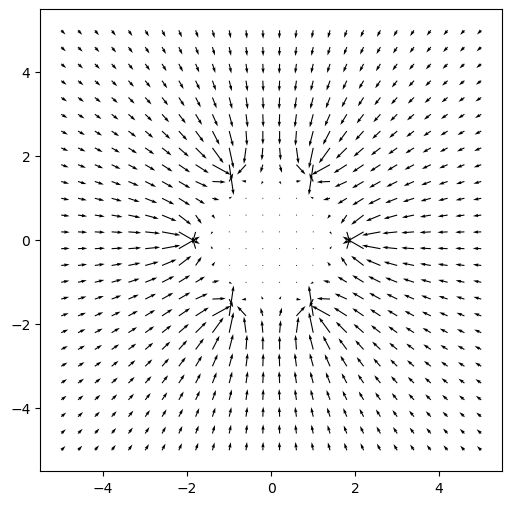

In [167]:
slc = slice(None, None, 4)
plt.figure(figsize=(6, 6))
plt.quiver(XX[slc, slc], YY[slc, slc], score_tsrs[slc, slc, 0], score_tsrs[slc, slc, 1])
# plt.contour(XX, YY, probs, levels=10)
plt.axis("image")

In [158]:
D_x, D_y, Laplacian = create_diff_operator(len(xspan), len(yspan), xspan[-1] - xspan[0], yspan[-1] - yspan[0])

In [162]:
# changing the strength of the eletric field, effectively scaling down the noise diffusion term. 
vec_scaling = 50
# find nan values, and replace them with 0
nan_mask = torch.isnan(score_vecs)
print("Number of nan values:", nan_mask.sum().item())
score_vecs_msk = score_vecs.clone() * vec_scaling
score_vecs_msk[nan_mask] = 0.0
Hopts =  Laplacian \
    - (diags_array(score_vecs_msk[:, 0].numpy()) @ D_x + diags_array(score_vecs_msk[:, 1].numpy()) @ D_y )

Number of nan values: 2


In [163]:
# is Hopts symmetric? no, it's not! 
print(Hopts.shape, "Hopts is symmetric?", (Hopts - Hopts.transpose()).nnz == 0)
num_eigenvalues = 25
eigenvalues, eigenvectors = eigs(Hopts, k=num_eigenvalues, which='SM')
# Reshape eigenvectors to 2D grid
eigenfunctions = [np.real(eigenvectors[:, i]).reshape(XX.shape) for i in range(num_eigenvalues)]
# Output first eigenvalue and eigenfunction
print("First eigenvalue:", eigenvalues[0])
print("First eigenfunction shape:", eigenfunctions[0].shape)

(10201, 10201) Hopts is symmetric? False
First eigenvalue: (-2.38573030408005+0j)
First eigenfunction shape: (101, 101)


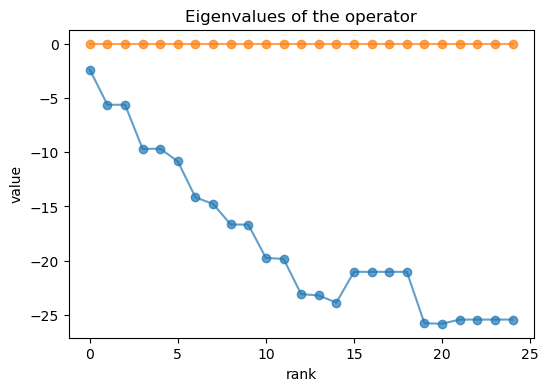

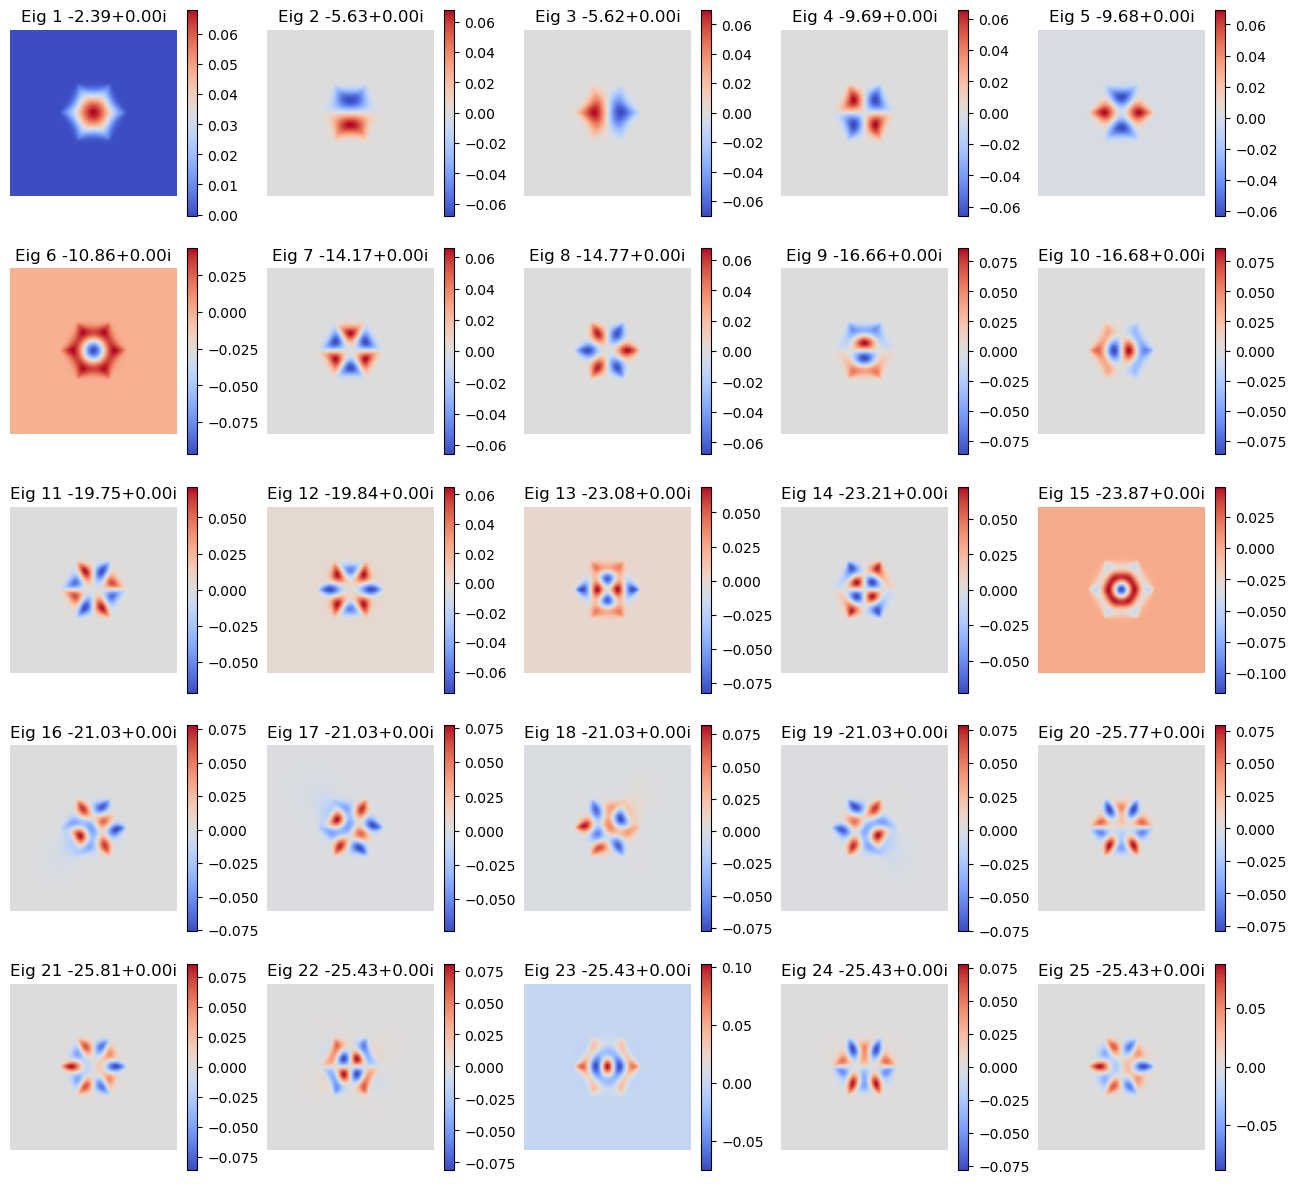

In [164]:
visualize_eigenmodes(eigenvalues, eigenvectors, XX.shape, num2plot=25)

In [64]:
mus.shape

torch.Size([6, 2])

In [ ]:
mus = th.tensor([np.cos(np.pi * np.arange(6) / 3), np.sin(np.pi * np.arange(6) / 3)]).T.float()
# covs = th.repeat_interleave(th.eye(2).unsqueeze(0), 3, dim=0) * sigma ** 2
covs = th.repeat_interleave(th.eye(2).unsqueeze(0), 6, dim=0) * sigma ** 2







gmm = GaussianMixture_torch(mus, covs, th.ones(mus.shape[0]) / mus.shape[0])



# visualize the density, score function vector field
xspan = np.linspace(-5, 5, 101)
yspan = np.linspace(-5, 5, 101)
XX, YY = np.meshgrid(xspan, yspan)
dx = xspan[1] - xspan[0]
dy = yspan[1] - yspan[0]
assert dx == dy
pnts = th.tensor(np.stack([XX, YY], axis=-1).reshape(-1, 2)).float()
score_vecs = gmm.score(pnts)
score_tsrs = score_vecs.reshape(*XX.shape, -1)
probs = gmm.pdf(pnts).reshape(*XX.shape)
noise_std = 0.1
noise = th.randn_like(score_vecs) * noise_std
score_vecs_noisy = score_vecs + noise

### Scratch

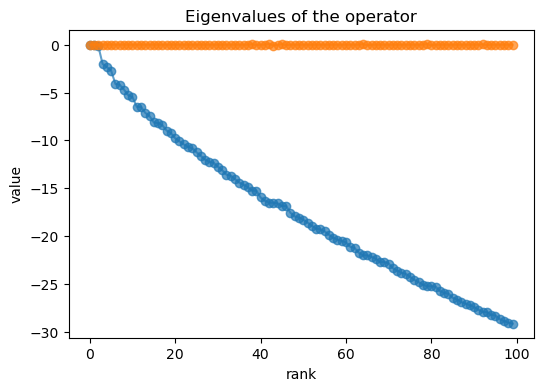

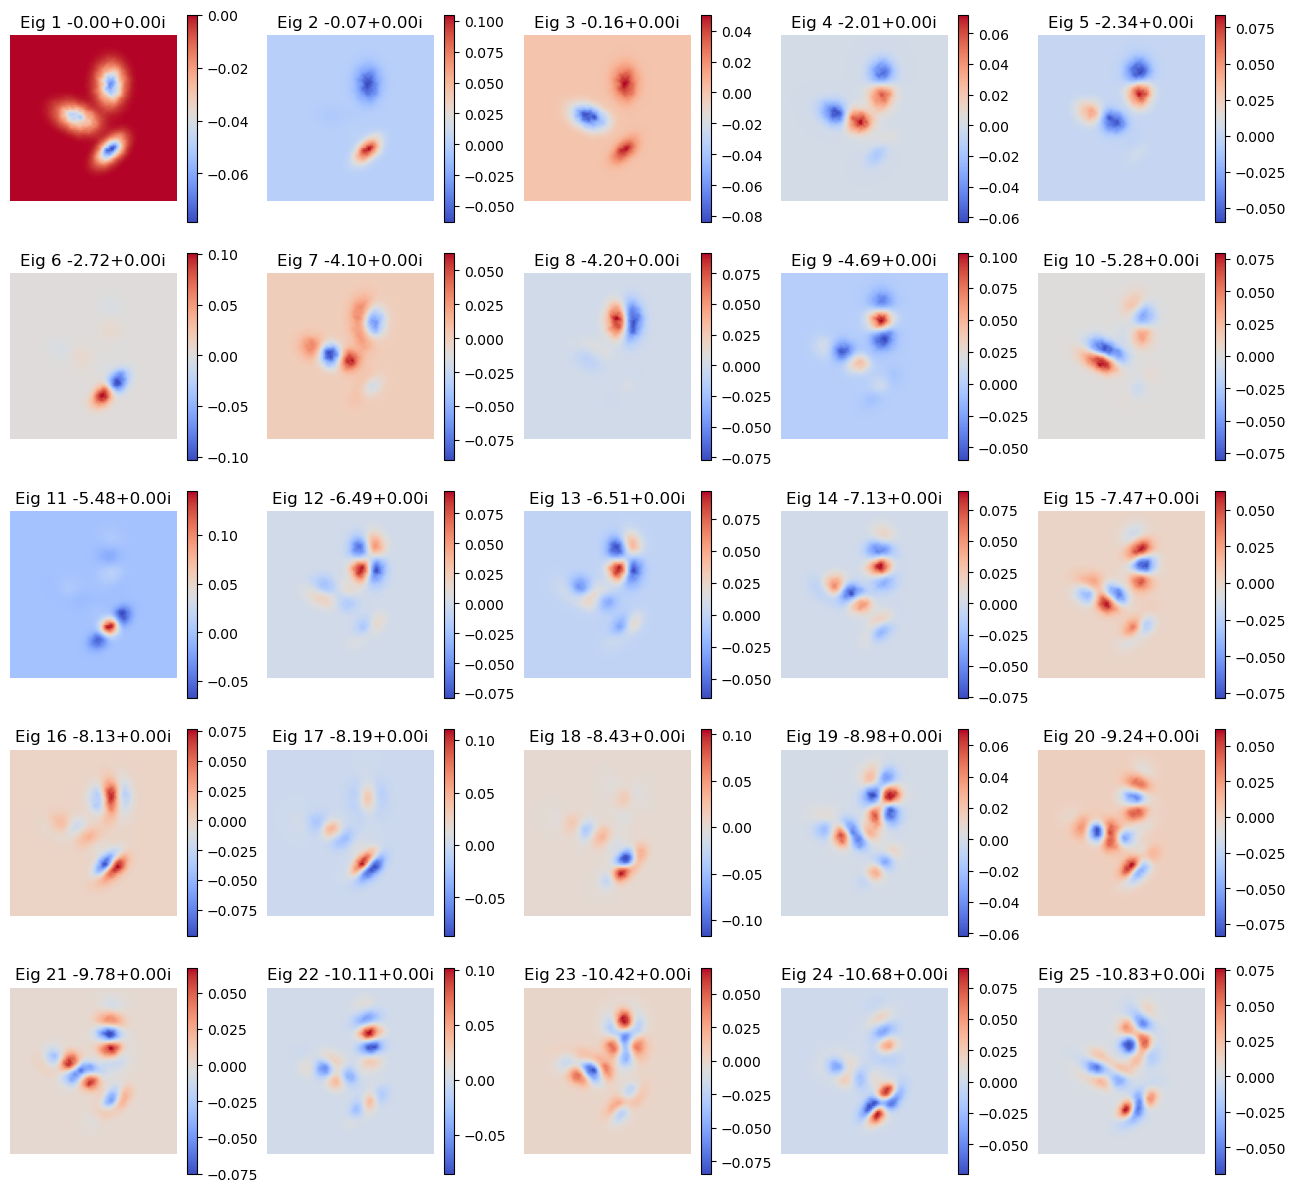

In [41]:
visualize_eigenmodes(eigenvalues, eigenvectors, XX.shape, num2plot=25)

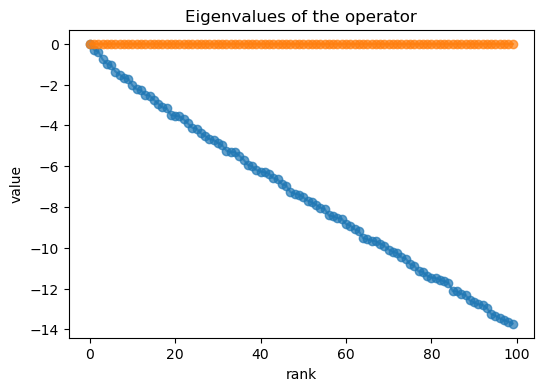

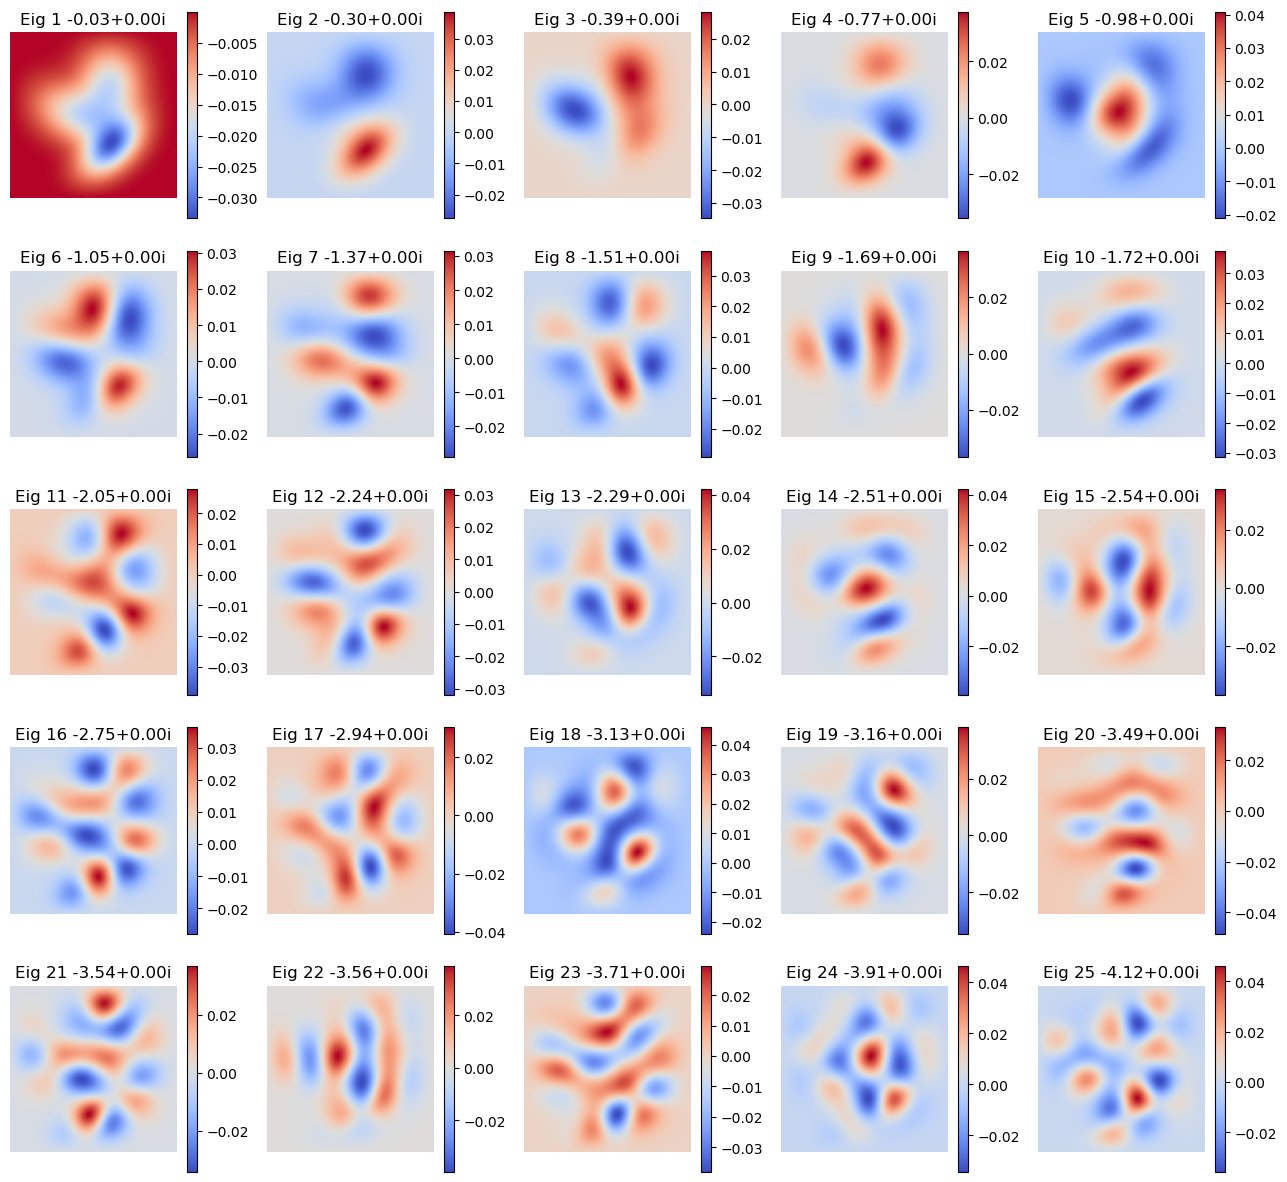

In [23]:
visualize_eigenmodes(eigenvalues, eigenvectors, XX.shape, num2plot=25)

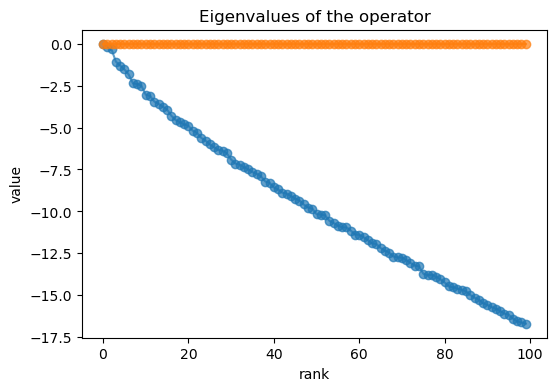

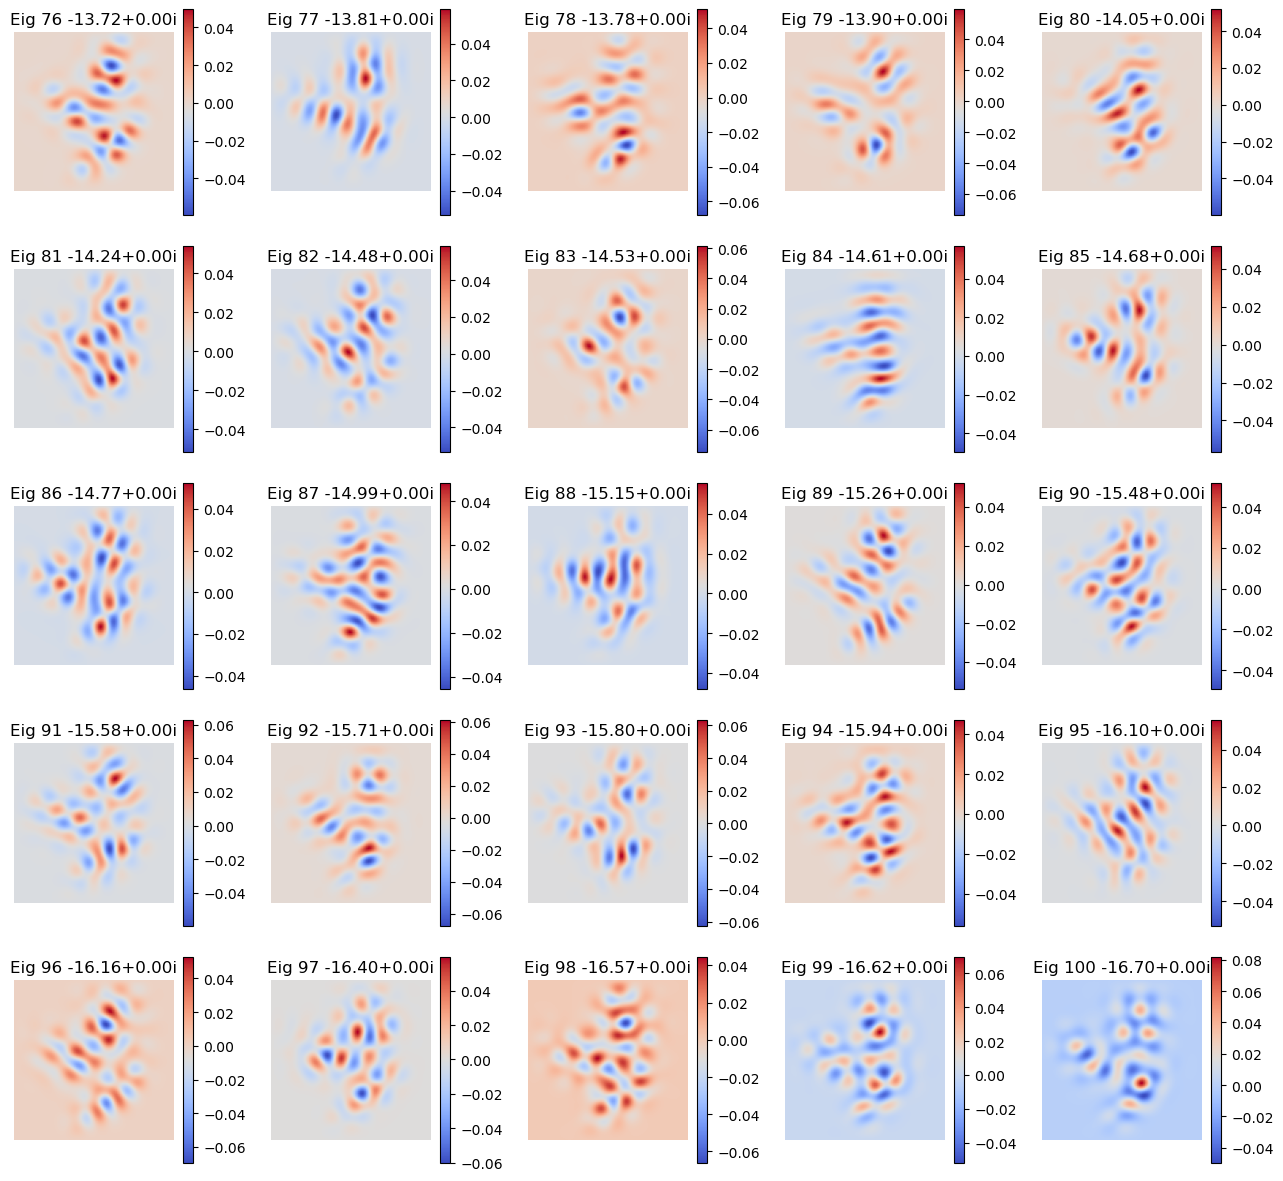

In [17]:
visualize_eigenmodes(eigenvalues, eigenvectors, XX.shape, num2plot=(75, 100)) 

## Scratch

### Implement the discrete differential operator

In [6]:
import numpy as np

def rolcol2linear_idx(Npnts, rowidv, colidv, do_wrap=False):
    # Ensure rowidv and colidv are numpy arrays
    rowidv = np.array(rowidv)
    colidv = np.array(colidv)
    
    if do_wrap:
        rowidv = rowidv % Npnts
        colidv = colidv % Npnts
        valmsk = np.ones(rowidv.size, dtype=bool)
        origidv = np.arange(rowidv.size)
    else:
        valmsk = (rowidv >= 0) & (rowidv < Npnts) & (colidv >= 0) & (colidv < Npnts)
        origidv = np.where(valmsk)[0]

    # Convert row and col indices to linear index
    mapidv = np.ravel_multi_index((rowidv[valmsk], colidv[valmsk]), (Npnts, Npnts))
    
    return mapidv, origidv

In [62]:
Npnts = 101 # number of points in each dimension
rowidx, colidx = np.meshgrid(np.arange(Npnts), np.arange(Npnts))
rowidx = rowidx.flatten()
colidx = colidx.flatten()
wrap = False
# build sparse matrix for the diffusion operator

mapidx, origidx = rolcol2linear_idx(Npnts, rowidx, colidx, do_wrap=wrap)
idxs = np.stack([mapidx, origidx], axis=0)
Spij = th.sparse_coo_tensor(idxs, np.ones_like(mapidx), size=(Npnts ** 2, Npnts ** 2), dtype=th.float32) 
mapidx, origidx = rolcol2linear_idx(Npnts, rowidx, colidx + 1, do_wrap=wrap)
idxs = np.stack([mapidx, origidx], axis=0)
Spijpls = th.sparse_coo_tensor(idxs, np.ones_like(mapidx), size=(Npnts ** 2, Npnts ** 2), dtype=th.float32)
mapidx, origidx = rolcol2linear_idx(Npnts, rowidx, colidx - 1, do_wrap=wrap)
idxs = np.stack([mapidx, origidx], axis=0)
Spijmns = th.sparse_coo_tensor(idxs, np.ones_like(mapidx), size=(Npnts ** 2, Npnts ** 2), dtype=th.float32)
mapidx, origidx = rolcol2linear_idx(Npnts, rowidx + 1, colidx, do_wrap=wrap)
idxs = np.stack([mapidx, origidx], axis=0)
Spiplsj = th.sparse_coo_tensor(idxs, np.ones_like(mapidx), size=(Npnts ** 2, Npnts ** 2), dtype=th.float32)
mapidx, origidx = rolcol2linear_idx(Npnts, rowidx - 1, colidx, do_wrap=wrap)
idxs = np.stack([mapidx, origidx], axis=0)
Spimnsj = th.sparse_coo_tensor(idxs, np.ones_like(mapidx), size=(Npnts ** 2, Npnts ** 2), dtype=th.float32)

In [63]:
Dx = (Spiplsj - Spimnsj) / (2) # / (dx)
Dy = (Spijpls - Spijmns) / (2) # / (dy)
Dxx = (Spiplsj - 2 * Spij + Spimnsj) # / (dx ** 2)
Dyy = (Spijpls - 2 * Spij + Spijmns) #/ (dy ** 2)
Lpls = Dxx + Dyy

### Torch eigen version

In [64]:
# eigen decomposition the Lpls
eigvals, eigvecs = th.linalg.eigh (Lpls.to_dense(), ) # .to_dense()

In [46]:
# eigen decomposition the Lpls
eigvals, eigvecs = th.linalg.eigh (Lpls.to_dense(), ) # .to_dense()

torch.Size([10201, 10201])

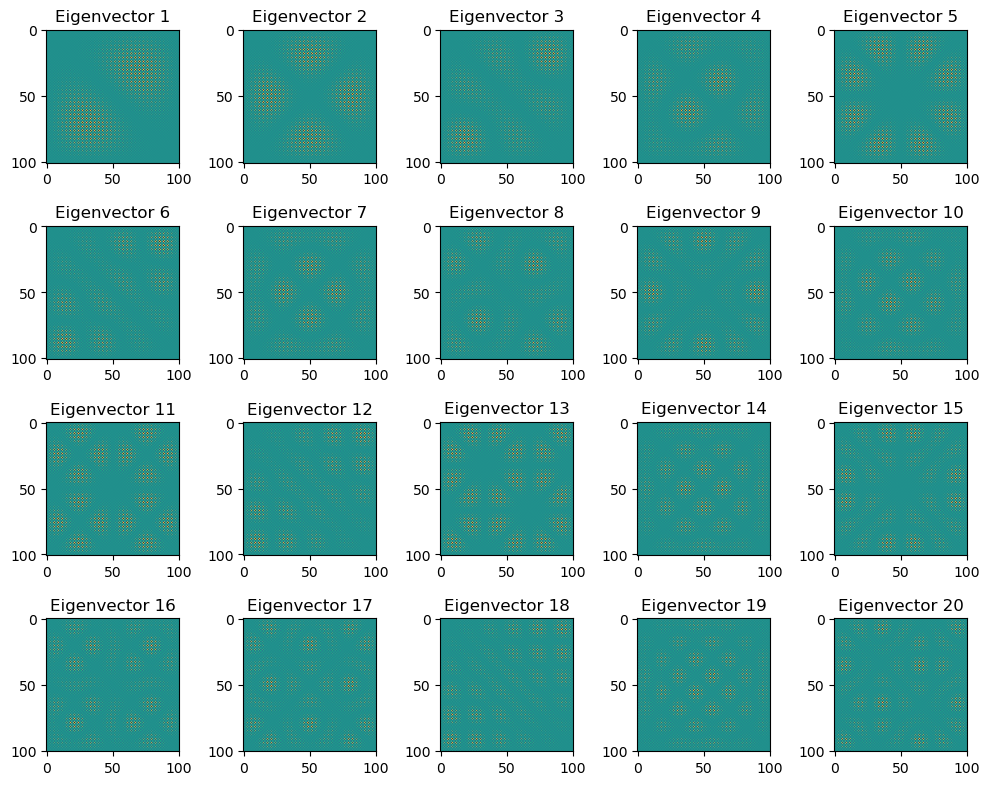

In [66]:
num_eigenvecs_to_plot = 20
fig, axes = plt.subplots(4, 5, figsize=(10, 8))
axes = axes.flatten()
for i in range(num_eigenvecs_to_plot):
    reshaped_eigenvec = eigvecs[:, -i-1].reshape(XX.shape)
    ax = axes[i]
    im = ax.imshow(reshaped_eigenvec, cmap='viridis')
    ax.set_title(f'Eigenvector {i+1}')
    # fig.colorbar(im, ax=ax)
plt.tight_layout()
plt.show()

In [68]:

SU,SS,SV = th.svd_lowrank (Lpls.to_dense(), q=20) # .to_dense()

In [70]:
SS

tensor([7.3706, 7.3655, 7.3502, 7.3365, 7.3313, 7.3051, 7.2998, 7.2966, 7.2908,
        7.2865, 7.2738, 7.2641, 7.2520, 7.2446, 7.2367, 7.2123, 7.2018, 7.1858,
        7.1778, 7.1677])

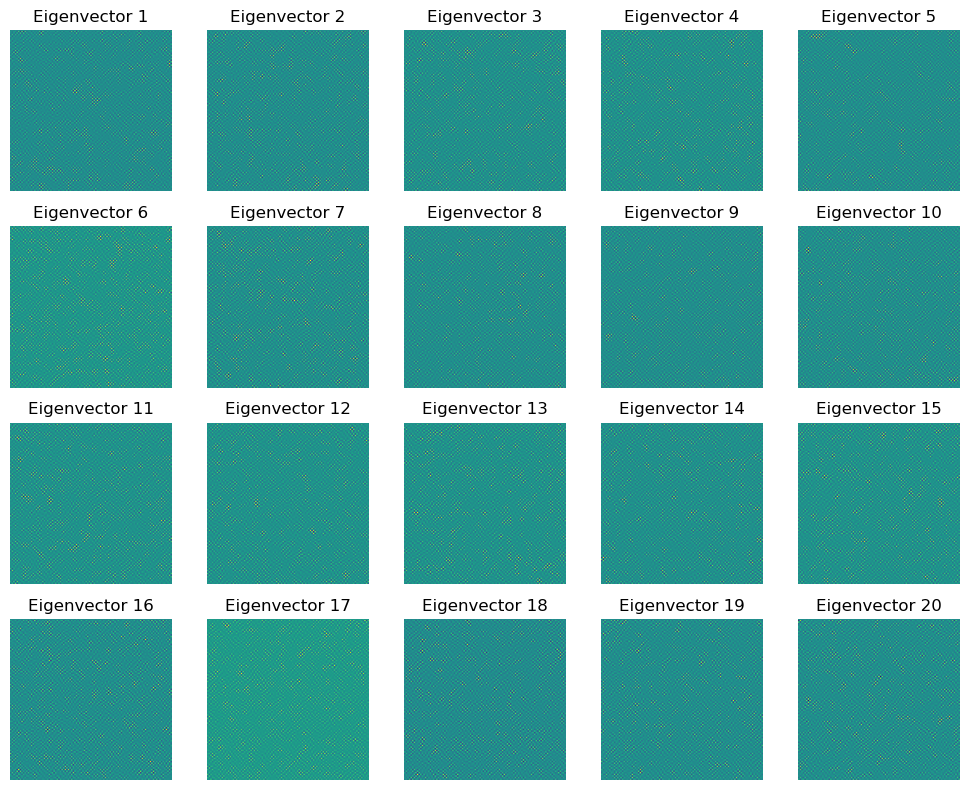

In [72]:
num_eigenvecs_to_plot = 20
fig, axes = plt.subplots(4, 5, figsize=(10, 8))
axes = axes.flatten()
for i in range(num_eigenvecs_to_plot):
    reshaped_eigenvec = SV[:, i].reshape(XX.shape)
    ax = axes[i]
    im = ax.imshow(reshaped_eigenvec, cmap='viridis')
    ax.set_title(f'Eigenvector {i+1}')
    ax.axis('off')
    # fig.colorbar(im, ax=ax)
plt.tight_layout()
plt.show()

### Numpy eigen version

In [265]:
rowidx, colidx = np.meshgrid(np.arange(5), np.arange(5))

In [268]:
rowidx

array([[0, 1, 2, 3, 4],
       [0, 1, 2, 3, 4],
       [0, 1, 2, 3, 4],
       [0, 1, 2, 3, 4],
       [0, 1, 2, 3, 4]])

In [7]:
from scipy.sparse import coo_array, diags_array

def create_discrete_derivatives_np(Npnts, wrap = False):
    colidx, rowidx = np.meshgrid(np.arange(Npnts), np.arange(Npnts))
    rowidx = rowidx.flatten()
    colidx = colidx.flatten()
    # build sparse matrix for the diffusion operator
    mapidx, origidx = rolcol2linear_idx(Npnts, rowidx, colidx, do_wrap=wrap)
    idxs = np.stack([mapidx, origidx], axis=0)
    Spij = coo_array((np.ones_like(mapidx), idxs), shape=(Npnts ** 2, Npnts ** 2), dtype=np.float32)
    mapidx, origidx = rolcol2linear_idx(Npnts, rowidx, colidx + 1, do_wrap=wrap)
    idxs = np.stack([mapidx, origidx], axis=0)
    Spijpls = coo_array((np.ones_like(mapidx), idxs), shape=(Npnts ** 2, Npnts ** 2), dtype=np.float32)
    mapidx, origidx = rolcol2linear_idx(Npnts, rowidx, colidx - 1, do_wrap=wrap)
    idxs = np.stack([mapidx, origidx], axis=0)
    Spijmns = coo_array((np.ones_like(mapidx), idxs), shape=(Npnts ** 2, Npnts ** 2), dtype=np.float32)
    mapidx, origidx = rolcol2linear_idx(Npnts, rowidx + 1, colidx, do_wrap=wrap)
    idxs = np.stack([mapidx, origidx], axis=0)
    Spiplsj = coo_array((np.ones_like(mapidx), idxs), shape=(Npnts ** 2, Npnts ** 2), dtype=np.float32)
    mapidx, origidx = rolcol2linear_idx(Npnts, rowidx - 1, colidx, do_wrap=wrap)
    idxs = np.stack([mapidx, origidx], axis=0)
    Spimnsj = coo_array((np.ones_like(mapidx), idxs), shape=(Npnts ** 2, Npnts ** 2), dtype=np.float32)
    # Dx = (Spiplsj - Spimnsj) / (2) # / (dx)
    # Dy = (Spijpls - Spijmns) / (2) # / (dy)
    # Dxx = (Spiplsj - 2 * Spij + Spimnsj) # / (dx ** 2)
    # Dyy = (Spijpls - 2 * Spij + Spijmns) #/ (dy ** 2)
    Dy = (Spiplsj - Spimnsj) / (2) # / (dx)
    Dx = (Spijpls - Spijmns) / (2) # / (dy)
    Dyy = (Spiplsj - 2 * Spij + Spimnsj) # / (dx ** 2)
    Dxx = (Spijpls - 2 * Spij + Spijmns) #/ (dy ** 2)
    Lpls = Dxx + Dyy
    return Dx, Dy, Dxx, Dyy, Lpls

In [98]:
Npnts = 101 # number of points in each dimension
rowidx, colidx = np.meshgrid(np.arange(Npnts), np.arange(Npnts))
rowidx = rowidx.flatten()
colidx = colidx.flatten()
wrap = False
# build sparse matrix for the diffusion operator

mapidx, origidx = rolcol2linear_idx(Npnts, rowidx, colidx, do_wrap=wrap)
idxs = np.stack([mapidx, origidx], axis=0)
Spij = coo_array((np.ones_like(mapidx), idxs), shape=(Npnts ** 2, Npnts ** 2), dtype=np.float32)
mapidx, origidx = rolcol2linear_idx(Npnts, rowidx, colidx + 1, do_wrap=wrap)
idxs = np.stack([mapidx, origidx], axis=0)
Spijpls = coo_array((np.ones_like(mapidx), idxs), shape=(Npnts ** 2, Npnts ** 2), dtype=np.float32)
mapidx, origidx = rolcol2linear_idx(Npnts, rowidx, colidx - 1, do_wrap=wrap)
idxs = np.stack([mapidx, origidx], axis=0)
Spijmns = coo_array((np.ones_like(mapidx), idxs), shape=(Npnts ** 2, Npnts ** 2), dtype=np.float32)
mapidx, origidx = rolcol2linear_idx(Npnts, rowidx + 1, colidx, do_wrap=wrap)
idxs = np.stack([mapidx, origidx], axis=0)
Spiplsj = coo_array((np.ones_like(mapidx), idxs), shape=(Npnts ** 2, Npnts ** 2), dtype=np.float32)
mapidx, origidx = rolcol2linear_idx(Npnts, rowidx - 1, colidx, do_wrap=wrap)
idxs = np.stack([mapidx, origidx], axis=0)
Spimnsj = coo_array((np.ones_like(mapidx), idxs), shape=(Npnts ** 2, Npnts ** 2), dtype=np.float32)

In [99]:
Dx = (Spiplsj - Spimnsj) / (2) # / (dx)
Dy = (Spijpls - Spijmns) / (2) # / (dy)
Dxx = (Spiplsj - 2 * Spij + Spimnsj) # / (dx ** 2)
Dyy = (Spijpls - 2 * Spij + Spijmns) #/ (dy ** 2)
Lpls = Dxx + Dyy

### Diffusion operator

In [8]:
import scipy.sparse.linalg as sla
import scipy.linalg as la

In [9]:
import torch as th 
import numpy as np
import matplotlib.pyplot as plt

sigma = 0.3
mus = th.tensor([[-1.0, 0.0], [1.0, 2.0], [1.0, -2.0]])
# covs = th.repeat_interleave(th.eye(2).unsqueeze(0), 3, dim=0) * sigma ** 2
covs = th.tensor([[[2.0, 0.5], [0.5, 1.0]],
                    [[1.0, -0.5], [-0.5, 1.0]],
                    [[1.0, 0.0], [0.0, 2.0]]]) * sigma ** 2
gmm = GaussianMixture_torch(mus, covs, th.tensor([0.3, 0.3, 0.4]))

/n/home12/binxuwang/Github/DiffusionOperatorSpectra/core/gaussian_mixture_lib.py:116: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.weights = torch.tensor(weights)


In [10]:
# visualize the density, score function vector field
xspan = np.linspace(-5, 5, 201)
yspan = np.linspace(-5, 5, 201)
XX, YY = np.meshgrid(xspan, yspan)
dx = xspan[1] - xspan[0]
dy = yspan[1] - yspan[0]
assert dx == dy
pnts = th.tensor(np.stack([XX, YY], axis=-1).reshape(-1, 2)).float()
score_vecs = gmm.score(pnts)
score_tsrs = score_vecs.reshape(*XX.shape, -1)
probs = gmm.pdf(pnts).reshape(*XX.shape)

(-5.0, 5.0, -5.0, 5.0)

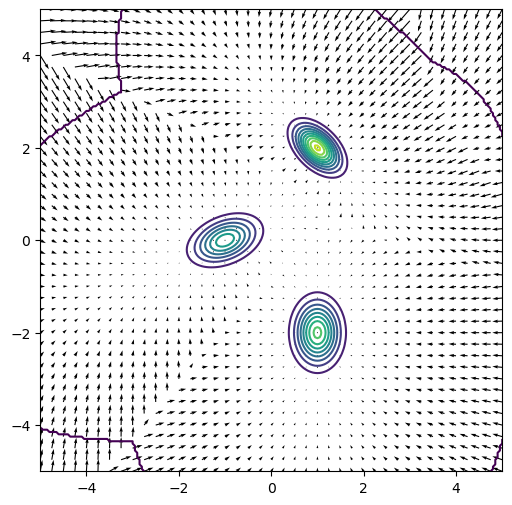

In [11]:
slc = slice(None, None, 5)
plt.figure(figsize=(6, 6))
plt.quiver(XX[slc, slc], YY[slc, slc], score_tsrs[slc, slc, 0], score_tsrs[slc, slc, 1])
plt.contour(XX, YY, probs, levels=10)
plt.axis("image")

In [12]:
Dx, Dy, Dxx, Dyy, Lpls = create_discrete_derivatives_np(len(xspan), wrap=False)
score_x = score_vecs[:, 0].numpy()
score_y = score_vecs[:, 1].numpy()
Hopt =  - (Dx @ diags_array(score_x) + Dy @ diags_array(score_y)) / dx + Lpls / (dx ** 2)

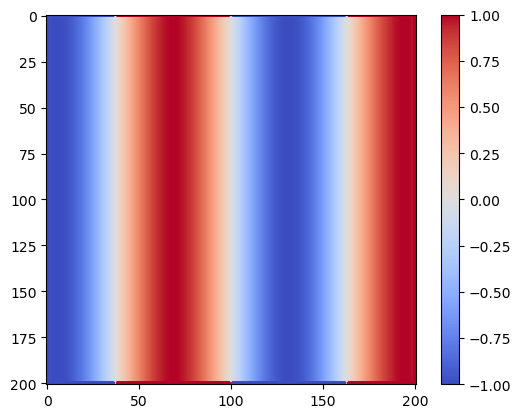

In [317]:
logprov_dx = Lpls @ (np.sin(XX).flatten()) / dx ** 2
# lpls_loglik = Dy @ score_x + Dx @ score_y
plt.imshow(logprov_dx.reshape(XX.shape), cmap='coolwarm', vmin=-1, vmax=1)#vmin=-0.02, vmax=.02)#vmin=-2, vmax=2
plt.colorbar()

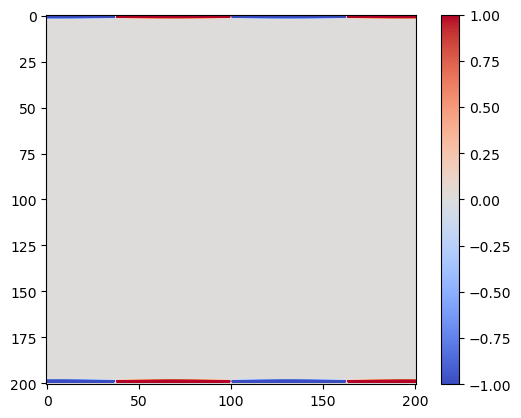

In [316]:
logprov_dx = Dy @ (Dy @ (np.sin(XX).flatten()) ) / dx ** 2
# lpls_loglik = Dy @ score_x + Dx @ score_y
plt.imshow(logprov_dx.reshape(XX.shape), cmap='coolwarm', vmin=-1, vmax=1)#vmin=-0.02, vmax=.02)#vmin=-2, vmax=2
plt.colorbar()

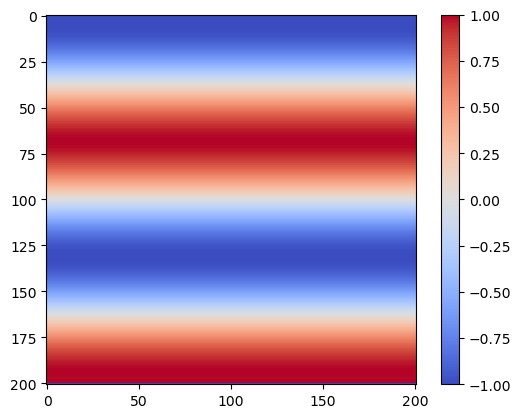

In [315]:
logprov_dx = Dy @ (Dy @ (np.sin(YY).flatten()) ) / dx ** 2
# lpls_loglik = Dy @ score_x + Dx @ score_y
plt.imshow(logprov_dx.reshape(XX.shape), cmap='coolwarm', vmin=-1, vmax=1)#vmin=-0.02, vmax=.02)#vmin=-2, vmax=2
plt.colorbar()

/tmp/ipykernel_2079844/1246477314.py:1: RuntimeWarning: divide by zero encountered in log
  logprov_dx = Lpls @ np.log(probs.flatten()) / dx ** 2


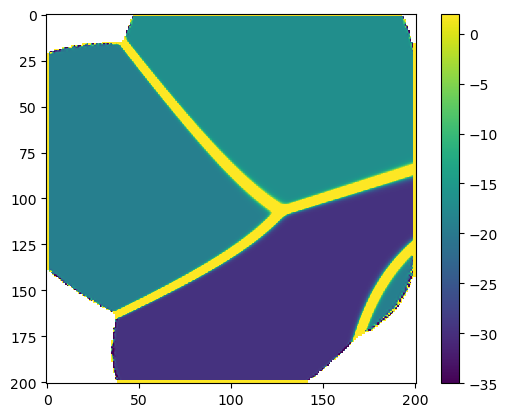

In [348]:
logprov_dx = Lpls @ np.log(probs.flatten()) / dx ** 2
# lpls_loglik = Dy @ score_x + Dx @ score_y
plt.imshow(logprov_dx.reshape(XX.shape), cmap='coolwarm', vmin=-35, vmax=2)
plt.colorbar()

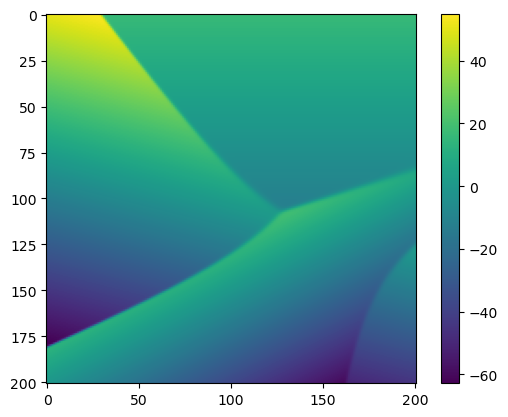

In [331]:
# lpls_loglik = Dx @ score_x + Dy @ score_y
# lpls_loglik = Dy @ score_x + Dx @ score_y
plt.imshow(score_y.reshape(XX.shape), cmap='viridis')
plt.colorbar()

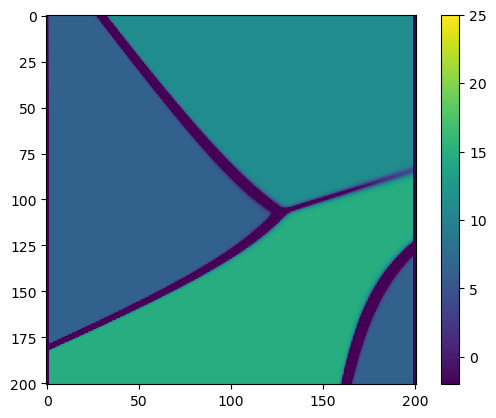

In [342]:
# lpls_loglik = Dx @ score_x + Dy @ score_y
# lpls_loglik = Dy @ score_x + Dx @ score_y
plt.imshow((Dx @ score_x / dx).reshape(XX.shape), cmap='viridis', vmin=-2, vmax=25)
plt.colorbar()

In [341]:
gmm.precs

[tensor([[ 6.3492, -3.1746],
         [-3.1746, 12.6984]]),
 tensor([[14.8148,  7.4074],
         [ 7.4074, 14.8148]]),
 tensor([[11.1111,  0.0000],
         [ 0.0000,  5.5556]])]

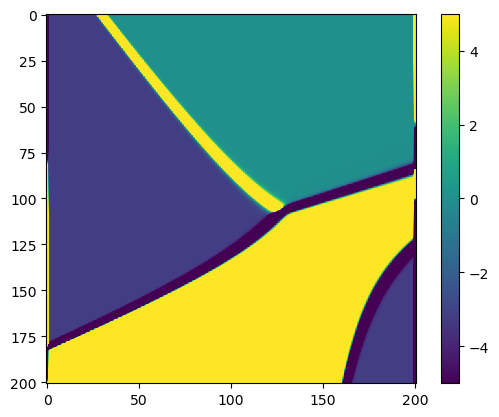

In [340]:
# lpls_loglik = Dx @ score_x + Dy @ score_y
# lpls_loglik = Dy @ score_x + Dx @ score_y
plt.imshow((Dx @ score_y / dx).reshape(XX.shape), cmap='viridis', vmin=-5, vmax=5)
plt.colorbar()

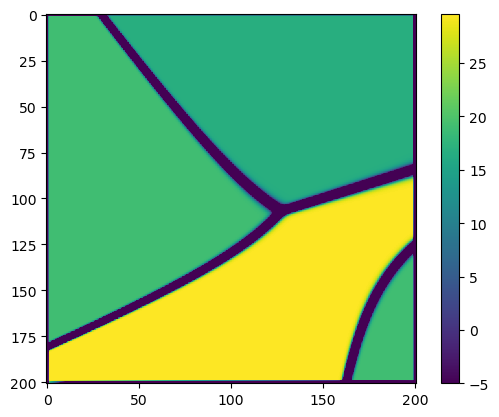

In [350]:
lpls_loglik = (Dx @ score_x + Dy @ score_y )/ dx
# lpls_loglik = Dy @ score_x + Dx @ score_y
plt.imshow(lpls_loglik.reshape(XX.shape), cmap='viridis', vmin=-5, )
plt.colorbar()

In [355]:

Hopt =  - (Dx @ diags_array(score_x) + Dy @ diags_array(score_y)) / dx + Lpls / (dx ** 2)

In [42]:
Hopt2 =  - diags_array(Dx @ score_x + Dy @ score_y) / dx \
         - (score_x[:,None,] * Dx + score_y[:,None,] * Dy) / dx \
         + Lpls / (dx ** 2)

In [47]:
Hopt3 =  - diags_array(Dx @ score_x + Dy @ score_y) / dx \
         - (diags_array(score_x) @ Dx + diags_array(score_y) @ Dy) / dx \
         + Lpls / (dx ** 2)

In [357]:
D, V = sla.eigs(Hopt, 20, sigma=0.01, which='LR',)

In [44]:
# D, V = sla.eigs(Hopt, 30, sigma=0.01, which='SM')
D, V = sla.eigs(Hopt2, 20, sigma=0.1, which='LM',)
# U, D, V = sla.svds(Hopt2, 20, which='SM')

In [48]:
D, V = sla.eigsh(Hopt3, 20, sigma=0.1, which='LM',)

In [51]:
D, V = sla.eigs(Hopt3, 20, sigma=0.1, which='LM',)

Text(0.5, 1.0, 'Eigenvalues of the operator')

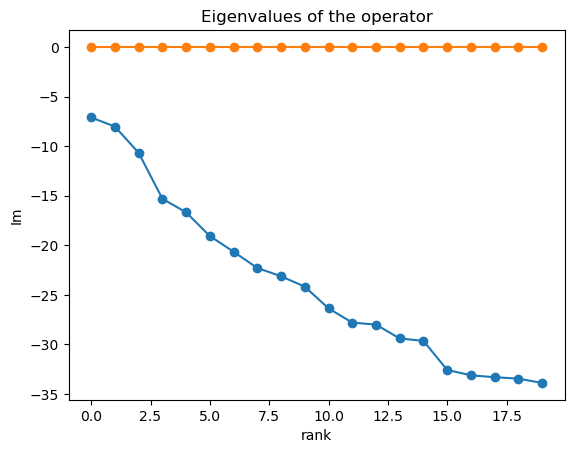

In [52]:
plt.plot(D.real, 'o-')
plt.plot(D.imag, 'o-')
plt.xlabel('rank')
plt.ylabel('Im')
plt.title('Eigenvalues of the operator')

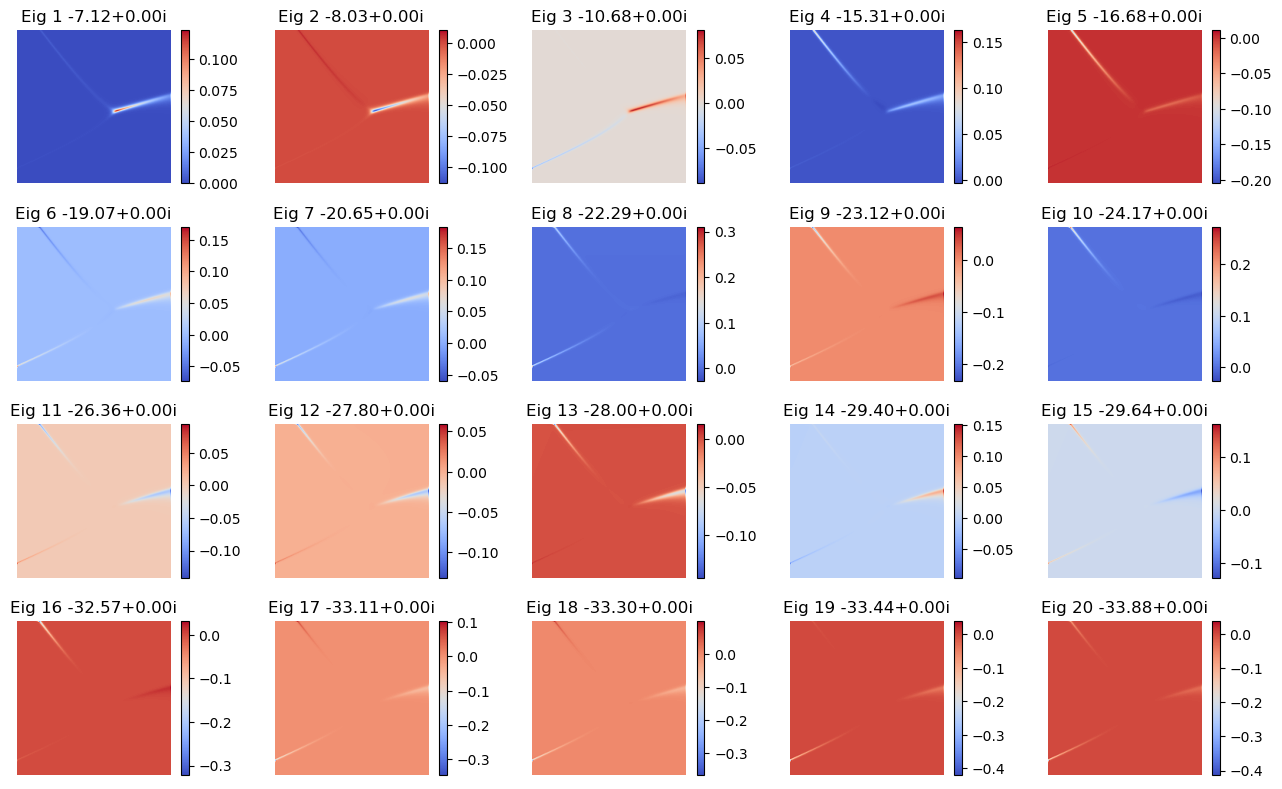

In [53]:
num_eigenvecs_to_plot = min(20, V.shape[1])
fig, axes = plt.subplots(4, 5, figsize=(13, 8))
axes = axes.flatten()
for i in range(num_eigenvecs_to_plot):
    reshaped_eigenvec = V.real[:, i].reshape(XX.shape)
    ax = axes[i]
    im = ax.imshow(reshaped_eigenvec, cmap='coolwarm')
    ax.set_title(f'Eig {i+1} {D[i].real:.2f}+{D[i].imag:.2f}i')
    ax.axis('off')
    fig.colorbar(im, ax=ax)
plt.tight_layout()
plt.show()

In [117]:
V.real

array([[ 6.98147049e-04,  2.53806131e-05, -3.40564348e-03, ...,
         4.94257381e-05,  7.41785156e-03,  7.01302977e-03],
       [ 1.15515957e-03,  5.11755921e-05, -5.61397562e-03, ...,
         1.87509381e-04,  1.21624033e-02,  1.14971036e-02],
       [ 1.46087945e-03,  8.34049468e-05, -7.05769043e-03, ...,
         4.50571810e-04,  1.51592537e-02,  1.43279806e-02],
       ...,
       [ 3.36042939e-04, -4.55443062e-05,  1.07195396e-03, ...,
        -1.43328498e-04, -3.16789761e-03, -2.12949219e-03],
       [ 2.63107745e-04, -3.24294659e-05,  8.41584466e-04, ...,
        -9.12446367e-05, -2.50107556e-03, -1.68117348e-03],
       [ 1.57321697e-04, -1.82114559e-05,  5.03992319e-04, ...,
        -4.68467333e-05, -1.50260657e-03, -1.01001023e-03]])

In [273]:
Dx, Dy, Dxx, Dyy, Lpls = create_discrete_derivatives_np(4, wrap=False)

In [ ]:
# SU,SS,SV = th.svd_lowrank(Hopt.to_dense(), q=20) # .to_dense()

AttributeError: 'csr_array' object has no attribute 'to_dense'

In [ ]:
SS

tensor([736.4813, 735.7528, 734.8655, 733.8691, 732.7740, 731.2674, 730.1381,
        728.8445, 728.0404, 727.4320, 726.3323, 725.0141, 724.5427, 723.2596,
        721.1970, 720.5035, 720.2369, 717.9089, 716.9449, 716.0709])

In [98]:
num_eigenvalues = 20
eigenvalues, eigenvectors = eigs(Hopts, k=num_eigenvalues, which='SM')
# Reshape eigenvectors to 2D grid
eigenfunctions = [np.real(eigenvectors[:, i]).reshape(XX.shape) for i in range(num_eigenvalues)]
# Output first eigenvalue and eigenfunction
print("First eigenvalue:", eigenvalues[0])
print("First eigenfunction shape:", eigenfunctions[0].shape)

First eigenvalue: (-0.0008972794499094161+0j)
First eigenfunction shape: (101, 101)


### Scratch space

In [ ]:
import numpy as np
from scipy.sparse import diags, kron, eye
from scipy.sparse.linalg import eigs

# Parameters
N_x = 50  # Number of grid points in x-direction
N_y = 50  # Number of grid points in y-direction
L_x = 1.0  # Length of the domain in x-direction
L_y = 1.0  # Length of the domain in y-direction
dx = L_x / (N_x - 1)  # Grid spacing in x
dy = L_y / (N_y - 1)  # Grid spacing in y

# Central difference matrix in 1D for x
D_x_1d = (1 / (2 * dx)) * diags([-1, 0, 1], [-1, 0, 1], shape=(N_x, N_x))
D_y_1d = (1 / (2 * dy)) * diags([-1, 0, 1], [-1, 0, 1], shape=(N_y, N_y))
DD_x_1d = (1 / dx**2) * diags([1, -2, 1], [-1, 0, 1], shape=(N_x, N_x))
DD_y_1d = (1 / dy**2) * diags([1, -2, 1], [-1, 0, 1], shape=(N_y, N_y))
I_x = eye(N_x)
I_y = eye(N_y)
D_x = kron(I_y, D_x_1d)  # d/dx operator for 2D
D_y = kron(D_y_1d, I_x)  # d/dy operator for 2D
Laplacian = kron(I_y, DD_x_1d) + kron(DD_y_1d, I_x)  # Laplacian
# Solve for eigenvalues and eigenvectors
num_eigenvalues = 10  # Number of eigenvalues to compute
eigenvalues, eigenvectors = eigs(Laplacian + D_x + D_y, k=num_eigenvalues, which='SM')
# Reshape eigenvectors to 2D grid
eigenfunctions = [np.real(eigenvectors[:, i]).reshape((N_x, N_y)) for i in range(num_eigenvalues)]
# Output first eigenvalue and eigenfunction
print("First eigenvalue:", eigenvalues[0])
print("First eigenfunction shape:", eigenfunctions[0].shape)

First eigenvalue: (-18.71469546519885+0j)
First eigenfunction shape: (50, 50)


In [ ]:
eigenvalues, eigenvectors = eigs(Laplacian + D_x + D_y, k=num_eigenvalues, which='SM')
# Reshape eigenvectors to 2D grid
eigenfunctions = [np.real(eigenvectors[:, i]).reshape((N_x, N_y)) for i in range(num_eigenvalues)]
# Output first eigenvalue and eigenfunction
print("First eigenvalue:", eigenvalues[0])
print("First eigenfunction shape:", eigenfunctions[0].shape)

First eigenvalue: (-18.714695465199007+0j)
First eigenfunction shape: (50, 50)


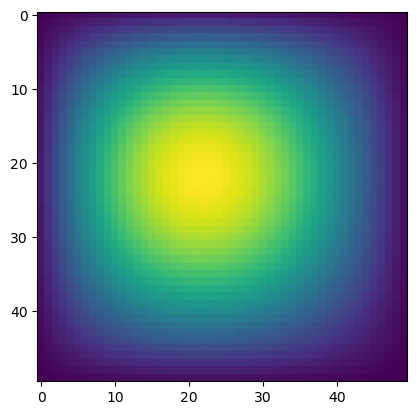

In [ ]:
plt.imshow(eigenfunctions[0].reshape(N_x, N_y), cmap='viridis')

In [ ]:
# Parameters
N = 50  # Number of grid points in each direction
L = 1.0  # Length of the domain
dx = L / (N - 1)  # Grid spacing
# # Discretize the Laplacian in 1D
DD = (1 / dx**2) * diags([1, -2, 1], [-1, 0, 1], shape=(N, N))
D  = (1 / dx / 2) * diags([-1, 1], [-1, 1], shape=(N, N))
# Construct 2D Laplacian using Kronecker product
I = eye(N)
Laplacian = kron(I, DD) + kron(DD, I)